In [3]:
import os
os.sys.path.append('./scripts')

# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [70]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'data/train.csv'
y_train, X_train, ids = load_csv_data(DATA_TRAIN_PATH, sub_sample=True)

feature_list = ["DER_mass_MMC", "DER_mass_transverse_met_lep", "DER_mass_vis", "DER_pt_h", "DER_deltaeta_jet_jet", "DER_mass_jet_jet",
                "DER_prodeta_jet_jet", "DER_deltar_tau_lep", "DER_pt_tot", "DER_sum_pt", "DER_pt_ratio_lep_tau", "DER_met_phi_centrality",
                "DER_lep_eta_centrality", "PRI_tau_pt", "PRI_tau_eta", "PRI_tau_phi", "PRI_lep_pt", "PRI_lep_eta", "PRI_lep_phi",
                "PRI_met", "PRI_met_phi", "PRI_met_sumet", "PRI_jet_num", "PRI_jet_leading_pt", "PRI_jet_leading_eta",
                "PRI_jet_leading_phi", "PRI_jet_subleading_pt", "PRI_jet_subleading_eta", "PRI_jet_subleading_phi", "PRI_jet_all_pt"]
feature_ids = {feature:i for i, feature in enumerate(feature_list)}

# TODO: remove some features in advance ???

In [3]:
def accuracy(y_pred, y_true):
    return np.sum(y_pred == y_true) / len(y_true)

In [74]:
def standardize(X, train_mean=None, train_std=None):
    """
    standardize X using z-score
    
    input custom mean and std in train_mean and train_std
    """
    if train_mean is None:
        train_mean = np.mean(X, axis=0)
    if train_std is None:
        train_std = np.std(X, axis=0)
    X = (X - train_mean) / (train_std + 1e-20)
    return X, train_mean, train_std

In [83]:
def distributions_plot(data, features):
    """
    This function visualize with histograms the distribution of each columns of the given data.

    Inputs: 
    data: a matrix, where each column is a sample of data from a distribution
    features: expect an array of names of the columns
    """
    #NEEDED DATA CLEANING
    col_num=data.shape[1]

    fig, axs = plt.subplots(col_num, figsize=(3,3*col_num))
    for i in range(col_num):
        axs[i].hist(data[:,i], bins=100) 
        axs[i].set_title(f'{features[i]}')

    #fig.suptitle('Distributions of the values of different features', fontsize=20)
    fig.tight_layout()

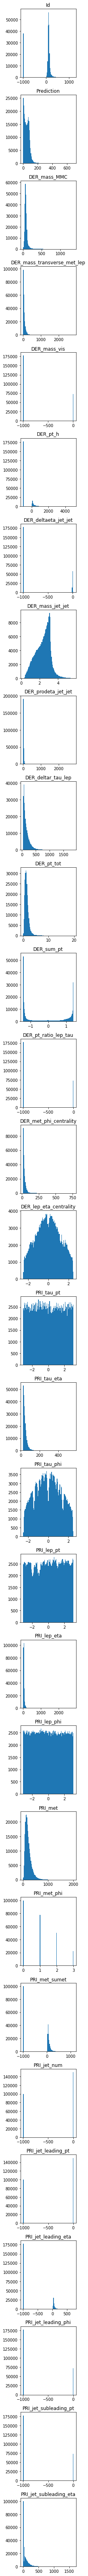

In [10]:
distributions_plot(X_train, features)

In [71]:
def impute_median(X, train_medians=None, nan_val=-999):
    """
        Replace nan_val by median in X
        Custom medians to use same median for training and testing can be 
        put into train_medians (otherwise use col medians of X)
        
        Returns X (median-imputed) and train_medians
    """
    if train_medians is None:
        train_medians = list()
        for i in range(X.shape[1]):
            missing_vals = (X[:,i] != nan_val)
            train_medians.append(np.median(X[missing_vals,i]))
    for i in range(X.shape[1]):
        missing_vals = (X[:,i] == nan_val)
        X[missing_vals,i] = train_medians[i] 
    return X, train_medians

In [75]:
def remove_outliers(X, y, upper_quart=None, lower_quart=None, custom_range=None):
    """Remove outliers, i.e. rows with values that are farther than 1.5 IQR from mean"""
    custom_keep = np.copy(X)
    if custom_range is not None:
        if len(custom_range) != X.shape[1]:
            raise ValueError("custom_range has wrong length!")
        for i in range(len(custom_range)):
            if custom_range[i] is not None:
                lower, upper = custom_range[i]
                custom_keep[:,i] = np.logical_and(custom_keep[:,i] >= lower, custom_keep[:,i] <= upper)
            else:
                custom_keep[:, i] = True
    else:
        custom_keep[:,:] = True
    
    if upper_quart is None:
        upper_quart = np.quantile(X, .75, axis=0)
    if lower_quart is None:
        lower_quart = np.quantile(X, .25, axis=0)
    IQR = upper_quart - lower_quart
    
    lower_bound = lower_quart - 1.5*IQR
    upper_bound = upper_quart + 1.5*IQR
    
    lower_bound = np.reshape(lower_bound, (1, len(lower_bound)))
    upper_bound = np.reshape(upper_bound, (1, len(upper_bound)))
    
    to_keep = np.all(np.logical_and(custom_keep, X >= lower_bound, X <= upper_bound), axis=1)

    X = X[to_keep, :]
    y = y[to_keep]
    
    return X, y, upper_quart, lower_quart

In [80]:
def bound_outliers(X, upper_quart=None, lower_quart=None):
    """
    Bound outliers, i.e. rows with values that are farther than 1.5 IQR
    from Lower/Upper quartile, to this quartile
    """
    if upper_quart is None:
        upper_quart = np.quantile(X, .75, axis=0)
    if lower_quart is None:
        lower_quart = np.quantile(X, .25, axis=0)
    IQR = upper_quart - lower_quart
    
    lower_bound = lower_quart - 1.5*IQR
    upper_bound = upper_quart + 1.5*IQR
    
    for i in range(X.shape[1]):
        too_low = (X[:,i] < lower_bound[i])
        X[too_low,i] = lower_bound[i]
        
        too_high = (X[:,i] > upper_bound[i])
        X[too_high,i] = upper_bound[i]
    
    return X, upper_quart, lower_quart

In [81]:
X_train, train_medians = impute_median(X_train)
X_train, train_upper_quart, train_lower_quart = bound_outliers(X_train)
print(X_train)

[[ 1.3847000e+02  5.1655000e+01  9.7827000e+01 ... -5.8000000e-02
  -1.7000000e-01  1.1349700e+02]
 [ 1.7976975e+02  7.2461000e+01  1.2483500e+02 ... -5.8000000e-02
  -1.7000000e-01  5.0396000e+01]
 [ 9.0801000e+01  2.7787000e+01  6.5373000e+01 ... -5.8000000e-02
  -1.7000000e-01  6.2766000e+01]
 ...
 [ 1.4234700e+02  7.3890000e+00  9.9212000e+01 ... -5.8000000e-02
  -1.7000000e-01  9.7068000e+01]
 [ 7.8162000e+01  4.6335000e+01  6.0136000e+01 ... -5.8000000e-02
  -1.7000000e-01  3.2440000e+01]
 [ 1.3004200e+02  4.0730000e+00  6.7819000e+01 ... -5.8000000e-02
  -1.7000000e-01  5.1037000e+01]]


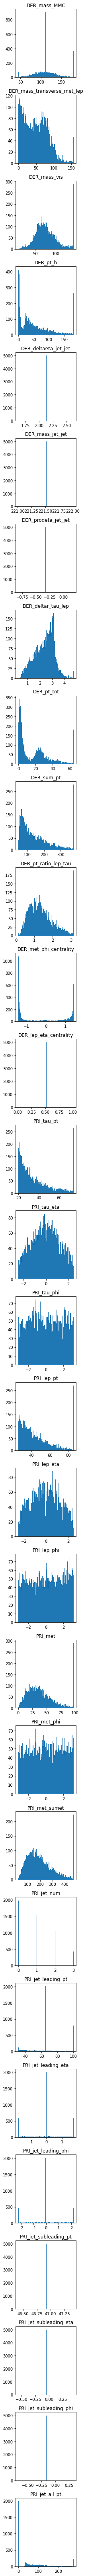

In [85]:
distributions_plot(X_train, feature_list)

In [17]:
def remove_custom_features(X, custom_feature_ids):
    X_cleaned = np.delete(X, custom_feature_ids, axis=1)
    return X_cleaned

In [6]:
def remove_tiny_features(X, threshold=1):
    d = X.shape[1]
    remove_features = []
    
    for i in range(d):
        unique_values = np.unique(X[:, i])
        if(len(unique_values) <=threshold):
            remove_features.append(i)

    X_cleaned = np.delete(X, remove_features, axis=1)
    return X_cleaned, remove_features

In [7]:
def build_poly(X, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    
    d = X.shape[1]
    X_poly = []
    for i in range(0, degree + 1):
        X_poly.append(X ** (i + 1))
        
    X_poly.append(np.ones((X.shape[0], 1)))
    X_poly = np.concatenate(X_poly, axis=1)
    
    
    """
    IT SEEMS THAT CURRENTLY SIN/COS FEATURES HARM PERFORMANCE
    
    # add sin and cos to basis
    X_sin = np.sin(X)
    X_cos = np.cos(X)
    X_poly = np.concatenate((X_poly, X_sin, X_cos), axis=1)
    """
    
    """
    # cross terms of second degree
    X_cross = []
    for i in range(d):
        for j in range(d):
            if i != j:
                X_cross.append((X[:, i] * X[:, j]).reshape(-1, 1))
                
    X_cross = np.concatenate(X_cross, axis=1)
    X_final = np.concatenate((X_poly, X_cross), axis=1)    
    return X_final
    """
    
    return X_poly

In [8]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)


def cross_validation(y, X, k_indices, k, degree, gamma, lambda_, max_iters, batch_size):
    """return the loss of ridge regression."""
    
    X, _ = remove_tiny_features(X)
    
    X_test = X[k_indices[k]]
    y_test = y[k_indices[k]]
    X_train = np.vstack([X[k_indices[i]] for i in range(k_indices.shape[0]) if not i == k])
    y_train = np.hstack([y[k_indices[i]] for i in range(k_indices.shape[0]) if not i == k])
    
    # remove outliers
    # impute values when they are missing (value -999 I think) (e.g. by median)
    
    X_test = build_poly(X_test, degree)
    X_train = build_poly(X_train, degree)
     
    X_train = standardize(X_train)
    X_test = standardize(X_test)
    
    w0 = np.zeros(X_train.shape[1])
    w, loss = reg_logistic_regression(y=y_train, tx=X_train, lambda_=lambda_, initial_w=w0, max_iters=max_iters, gamma=gamma, batch_size=batch_size)
    
    y_train_pred = predict_labels(w, X_train)
    y_test_pred = predict_labels(w, X_test)
    
    acc_train = accuracy(y_train_pred, y_train)
    acc_test = accuracy(y_test_pred, y_test)
    return acc_train, acc_test

In [9]:
def split_data_by_feature(y, X, ids, feature_id, train=True):
    unique_values = np.unique(X[:, feature_id])
    X_new = np.delete(X, feature_id, axis=1)
    splits = {}
    for value in unique_values:
        X_cur = X_new[np.where(X[:, feature_id] == value)]
        y_cur = None
        if(train):
            y_cur = y[np.where(X[:, feature_id] == value)]
        else:
            y_cur = ids[np.where(X[:, feature_id] == value)]
        ids_cur = ids[np.where(X[:, feature_id] == value)]
        splits[value] = (X_cur, y_cur, ids_cur)
        
    return splits

In [10]:
data_splits_train = split_data_by_feature(y_train, X_train, ids, feature_ids["PRI_jet_num"], train=True)

# Define hyperparameters
seed = 44
k_fold = 10

max_iters = 300
batch_size = 100

# MAYBE RANGES SHOULD BE SELECTED BETTER???
gammas = np.logspace(-4, -1, 4)     # learning rate   
degrees = [1, 2, 3, 4, 5]           # polynomial expansion degree
lambdas = np.logspace(-4, 0, 5)     # regularization constant

accs_train = {}
accs_test = {}


# perform k-fold cross validation for each dataset (jet) separately
for jet in data_splits_train.keys():
    X_train_jet, y_train_jet, _ = data_splits_train[jet]
    
    print(f"JET NUMBER {int(jet)}:")
    
    
    # split data in k fold
    k_indices = build_k_indices(y_train_jet, k_fold, seed)

    # define lists to store the accuracies of training data and test data
    accs_train_jet = np.zeros((len(degrees), len(gammas), len(lambdas)))
    accs_test_jet = np.zeros((len(degrees), len(gammas), len(lambdas)))

    for id_degree, degree in enumerate(degrees):
        for id_gamma, gamma in enumerate(gammas):
            for id_lambda, lambda_ in enumerate(lambdas):
                cur_acc_train = np.zeros(k_fold)
                cur_acc_test = np.zeros(k_fold)

                for k in range(k_fold):
                    acc_train, acc_test = cross_validation(y=y_train_jet, X=X_train_jet, k_indices=k_indices, k=k, 
                                                           degree=degree, gamma=gamma, lambda_=lambda_, 
                                                           max_iters=max_iters, batch_size=batch_size)

                    cur_acc_train[k] = acc_train
                    cur_acc_test[k] = acc_test

                accs_train_jet[id_degree, id_gamma, id_lambda] = cur_acc_train.mean()
                accs_test_jet[id_degree, id_gamma, id_lambda] = cur_acc_test.mean()
                print(f"Degree: {degree:2}, Learning rate: {gamma:6}, Lambda: {lambda_:6}: Train: {cur_acc_train.mean():.4f} +- {cur_acc_train.std():.4f}, Test: {cur_acc_test.mean():.4f} +- {cur_acc_test.std():.4f}")

    accs_train[jet] = accs_train_jet
    accs_test[jet] = accs_test_jet

JET NUMBER 0:
Degree:  1, Learning rate: 0.0001, Lambda: 0.0001: Train: 0.6949 +- 0.0054, Test: 0.6843 +- 0.0361
Degree:  1, Learning rate: 0.0001, Lambda:  0.001: Train: 0.6955 +- 0.0073, Test: 0.6939 +- 0.0395
Degree:  1, Learning rate: 0.0001, Lambda:   0.01: Train: 0.6966 +- 0.0057, Test: 0.6919 +- 0.0424
Degree:  1, Learning rate: 0.0001, Lambda:    0.1: Train: 0.6957 +- 0.0070, Test: 0.6929 +- 0.0400
Degree:  1, Learning rate: 0.0001, Lambda:    1.0: Train: 0.6945 +- 0.0040, Test: 0.6914 +- 0.0393
Degree:  1, Learning rate:  0.001, Lambda: 0.0001: Train: 0.7412 +- 0.0069, Test: 0.7348 +- 0.0440
Degree:  1, Learning rate:  0.001, Lambda:  0.001: Train: 0.7401 +- 0.0071, Test: 0.7298 +- 0.0439
Degree:  1, Learning rate:  0.001, Lambda:   0.01: Train: 0.7418 +- 0.0074, Test: 0.7318 +- 0.0422
Degree:  1, Learning rate:  0.001, Lambda:    0.1: Train: 0.7423 +- 0.0072, Test: 0.7298 +- 0.0462
Degree:  1, Learning rate:  0.001, Lambda:    1.0: Train: 0.7360 +- 0.0078, Test: 0.7338 +- 0.0

/home/postuvan/EPFL/ML_project1/./scripts/implementations.py:77: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-z))


Degree:  4, Learning rate:    0.1, Lambda: 0.0001: Train: 0.6485 +- 0.0584, Test: 0.6399 +- 0.0605
Degree:  4, Learning rate:    0.1, Lambda:  0.001: Train: 0.6606 +- 0.0585, Test: 0.6631 +- 0.0677
Degree:  4, Learning rate:    0.1, Lambda:   0.01: Train: 0.6383 +- 0.0492, Test: 0.6369 +- 0.0630
Degree:  4, Learning rate:    0.1, Lambda:    0.1: Train: 0.6192 +- 0.0605, Test: 0.6157 +- 0.0654
Degree:  4, Learning rate:    0.1, Lambda:    1.0: Train: 0.5709 +- 0.0625, Test: 0.5934 +- 0.0658
Degree:  5, Learning rate: 0.0001, Lambda: 0.0001: Train: 0.7054 +- 0.0090, Test: 0.7096 +- 0.0394
Degree:  5, Learning rate: 0.0001, Lambda:  0.001: Train: 0.7042 +- 0.0077, Test: 0.7076 +- 0.0325
Degree:  5, Learning rate: 0.0001, Lambda:   0.01: Train: 0.7052 +- 0.0093, Test: 0.7131 +- 0.0337
Degree:  5, Learning rate: 0.0001, Lambda:    0.1: Train: 0.7080 +- 0.0095, Test: 0.7121 +- 0.0320
Degree:  5, Learning rate: 0.0001, Lambda:    1.0: Train: 0.7068 +- 0.0081, Test: 0.7111 +- 0.0355
Degree:  5

In [11]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'data/train.csv'
y_train_whole, X_train_whole, ids = load_csv_data(DATA_TRAIN_PATH, sub_sample=False)

custom_range = [(0,inf), None, None, None, None, (0,inf), None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, (0,inf), None, None, (0,inf), None, None, None]
X_train_whole, y_train_whole = remove_outliers(X_train_whole, y_train_whole, custom_range)

id_degree, id_lambda = np.unravel_index(np.argmax(accs_test), accs_test.shape)
degree, lambda_ = degrees[id_degree], lambdas[id_lambda]
data_splits_train_whole = split_data_by_feature(y_train_whole, X_train_whole, ids, feature_ids["PRI_jet_num"], train=True)

weights = {}
best_degrees = {}

all_preds = []
all_labels = []
removed_features = {}
for jet in data_splits_train_whole.keys():
    X_train_whole_jet, y_train_whole_jet, _ = data_splits_train_whole[jet]
    
    id_degree, id_gamma, id_lambda = np.unravel_index(np.argmax(accs_test[jet]), accs_test[jet].shape)
    degree, gamma, lambda_ = degrees[id_degree], gammas[id_gamma], lambdas[id_lambda]
    best_degrees[jet] = degree
    
    X_train_whole_jet, removed_features_jet = remove_tiny_features(X_train_whole_jet)
    removed_features[jet] = removed_features_jet
    
    # remove outliers
    # impute values when they are missing (value -999 I think) (e.g. by median)
    
    X_train_whole_jet = build_poly(X_train_whole_jet, degree)
    X_train_whole_jet = standardize(X_train_whole_jet)

    w0 = np.zeros(X_train_whole_jet.shape[1])
    w, loss = reg_logistic_regression(y=y_train_whole_jet, tx=X_train_whole_jet, lambda_=lambda_, initial_w=w0, max_iters=max_iters, gamma=gamma, batch_size=batch_size)
    weights[jet] = w
        
    y_train_pred = predict_labels(w, X_train_whole_jet)
    acc_train = accuracy(y_train_pred, y_train_whole_jet)
    print(f"JET {jet}: Train accuracy: {acc_train:.4f}")
        
    all_preds.append(y_train_pred)
    all_labels.append(y_train_whole_jet)

    
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
acc_train_whole = accuracy(all_preds, all_labels)
print(f"TOGETHER: Train accuracy on train data: {acc_train_whole:.4f}")

JET 0.0: Train accuracy: 0.7375
JET 1.0: Train accuracy: 0.6977
JET 2.0: Train accuracy: 0.7514
JET 3.0: Train accuracy: 0.6597
TOGETHER: Train accuracy on train data: 0.7211


## Generate predictions and save ouput in csv format for submission:

In [12]:
DATA_TEST_PATH = './data/test.csv'
_, X_test, ids_test = load_csv_data(DATA_TEST_PATH)
data_splits_test = split_data_by_feature(None, X_test, ids_test, feature_ids["PRI_jet_num"], train=False)


all_preds = []
all_ids = []
for jet in data_splits_test.keys():
    X_test_jet, _, ids_jet = data_splits_test[jet]
    
    X_test_jet = remove_custom_features(X_test_jet, custom_feature_ids=removed_features[jet])
    
    # remove outliers
    # impute values when they are missing (value -999 I think) (e.g. by median)
    
    X_test_jet = build_poly(X_test_jet, best_degrees[jet])
    X_test_jet = standardize(X_test_jet)
    
    y_test_pred = predict_labels(weights[jet], X_test_jet, competition=True)
    
    all_preds.append(y_test_pred)
    all_ids.append(ids_jet)

all_preds = np.concatenate(all_preds, axis=0)
all_ids = np.concatenate(all_ids, axis=0)

In [13]:
OUTPUT_PATH = './predictions/predictions.csv'
create_csv_submission(all_ids, all_preds, OUTPUT_PATH)